# Conifer Synthesis with GradientBoost BDT on ATLAS Tau Data

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics
import conifer
import datetime
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import pickle
import sklearn.ensemble

### Load data

In [2]:
def open_params_used(filename):
    with open(filename, "r") as f:
        return f.read().split()

In [3]:
params_used = open_params_used("params5_used.txt")
params_used

['reco_pt', 'reco_eta', 'reco_frac2', 'reco_max1', 'reco_max2']

In [4]:
def load_data(sig_filename, bg_filename, features):
    """ Returns X, Y for data stored in csv file"""
    
    sig_df = pd.read_csv(sig_filename)[features]
    bg_df = pd.read_csv(bg_filename)[features]
    
    sig_df["signal"] = 1
    bg_df["signal"] = 0
    
    df  = pd.concat([sig_df, bg_df], ignore_index=True)
    
    X = df.to_numpy()[:, :-1]
    Y = df.to_numpy()[:, -1][np.newaxis].transpose()
    # Y = np.reshape(Y, (Y.shape[0], 1))
    
    return df, X, Y

In [5]:
df, X, Y = load_data("~/tdata/sig.csv", "~/tdata/bg.csv", params_used)

In [6]:
display(df.head())
display(df["signal"].value_counts())

,reco_pt,reco_eta,reco_frac2,reco_max1,reco_max2,signal
0,22125.000000,0.55,0.668927,12.150,0.150,1
1,8375.000000,0.85,0.707463,2.625,0.925,1
2,10850.000381,0.95,0.605991,2.500,0.775,1
3,23549.999237,1.75,0.516985,4.500,2.475,1
4,8175.000191,0.05,0.186544,0.400,0.325,1


0    2551567
1      87629
Name: signal, dtype: int64

In [7]:
print(X.shape)
print(Y.shape)
print(np.concatenate((X, Y), axis=1).shape)

(2639196, 5)
(2639196, 1)
(2639196, 6)


### Split data into test/train subsets

In [8]:
def split_data(X, Y, test_percent=0.1):
    """returns X_train, Y_train, X_test, Y_test """
    total = np.concatenate((X, Y), axis=1)
    np.random.shuffle(total)
    n_X = (int) ((1 - test_percent) * total.shape[0])
    
    X_train = total[:n_X, :-1]
    X_test = total[n_X:, :-1]
    
    Y_train = total[:n_X, -1][np.newaxis].transpose()
    Y_test = total[n_X:, -1][np.newaxis].transpose()
    
    return X_train, Y_train, X_test, Y_test

In [9]:
X_train_val, y_train_val, X_test, y_test = split_data(X, Y)
print(f"X_train: {X_train_val.shape} Y_train: {y_train_val.shape}")
print(f"X_test: {X_test.shape} Y_test: {y_test.shape}")

X_train: (2375276, 5) Y_train: (2375276, 1)
X_test: (263920, 5) Y_test: (263920, 1)


### Load GradientBoostingClassifier

In [11]:
with open('GradientBoosted_params5_trees50_depth2.pkl', 'rb') as f:
    clf = pickle.load(f)

### Determine model accuracy

In [12]:
from sklearn.metrics import accuracy_score
y_predict = clf.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, y_predict)))

Accuracy: 0.9752273416186723


### Determine AUCs and ROC curves

In [34]:
y_score = clf.decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = sklearn.metrics.roc_curve(y_test, y_score)
roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

### Plot ROC Curve

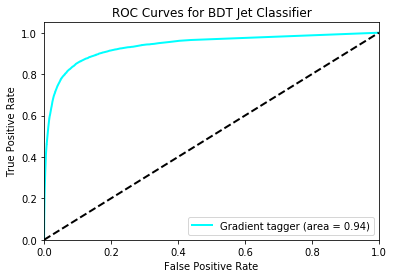

In [17]:
# Plot all ROC curves
plt.figure()

lw=2
classes=['Gradient']
n_classes=len(list(classes))

from itertools import cycle
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label= list(classes)[i] + ' tagger (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for BDT Jet Classifier')
plt.legend(loc="lower right")
plt.show()

### Plot ROC Curve as Signal Efficiency vs Log of Background Efficiency

/home/vovechki/miniconda3/envs/conifer-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


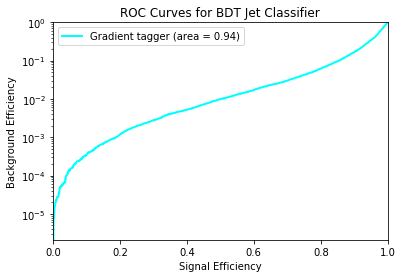

In [18]:
# Plot all ROC curves
plt.figure()

lw=2
classes=['Gradient']
n_classes=len(list(classes))

from itertools import cycle
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(tpr[i], fpr[i], color=color, lw=lw,
             label= list(classes)[i] + ' tagger (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.semilogy()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Efficiency')
plt.title('ROC Curves for BDT Jet Classifier')
plt.legend(loc="upper left")
plt.show()

### Generate confusion matrix

In [21]:
cm =sklearn.metrics.confusion_matrix(y_test, y_predict, labels=classes)

/home/vovechki/miniconda3/envs/conifer-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif np.all([l not in y_true for l in labels]):


ValueError: At least one label specified must be in y_true

In [ ]:
# confusion matrix code from Maurizio
# /eos/user/m/mpierini/DeepLearning/ML4FPGA/jupyter/HbbTagger_Conv1D.ipynb
def plot_confusion_matrix(cm, classes,
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    cbar = plt.colorbar()
    plt.clim(0,1)
    cbar.set_label(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(cm,classes, normalize=True)

### Perform model synthesis

In [24]:
# Create a conifer config
cfg = conifer.backends.vivadohls.auto_config()
# Set the output directory to something unique
cfg['OutputDir'] = 'tauTrees/prj_1605048046/rj_{}'.format(int(datetime.datetime.now().timestamp()))
cfg['XilinxPart'] = 'xc7vx690tffg1761-2'

# Create and compile the model
model = conifer.model(clf, conifer.converters.sklearn, conifer.backends.vivadohls, cfg)
model.compile()

# Run HLS C Simulation and get the output
y_conif = model.decision_function(X_test)

# Synthesize the model
model.build()

### Generate Resource Reports

In [26]:
import hls4ml
hls4ml.report.read_vivado_report(cfg['OutputDir'])

Found 1 solution(s) in tauTrees/prj_1605048046/my_prj_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'my_prj'
* Date:           Tue Nov 10 16:42:13 2020

* Version:        2018.2 (Build 2258646 on Thu Jun 14 20:25:20 MDT 2018)
* Project:        my_prj_prj
* Solution:       solution1
* Product family: virtex7
* Target device:  xc7vx690tffg1761-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.135|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   26|   26|   25|   25| function |
    +-----+-----+-----+-----+----------+

 

### Generate ROC curve metrics for ADA model

In [43]:
def open_model(filename):
    """ Returns sklearn stored in pickle file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [52]:
model = open_model("../../params5_trees800_depth4.pkl")
model

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=4),
                   n_estimators=800)

In [53]:
y_ada = model.decision_function(X_test)
fpr_ada = dict()
tpr_ada = dict()
roc_auc_ada = dict()

fpr_ada[0], tpr_ada[0], _ = sklearn.metrics.roc_curve(y_test, y_ada)
roc_auc_ada[i] = sklearn.metrics.auc(fpr_ada[i], tpr_ada[i])

### Generate ROC curve metrics for conifer model

In [33]:
fpr_conif = dict()
tpr_conif = dict()
roc_auc_conif = dict()

fpr_conif[0], tpr_conif[0], _ = sklearn.metrics.roc_curve(y_test, y_conif)
roc_auc_conif[i] = sklearn.metrics.auc(fpr_conif[i], tpr_conif[i])

### Plot ROC curves comparing sklearn model to conifer model

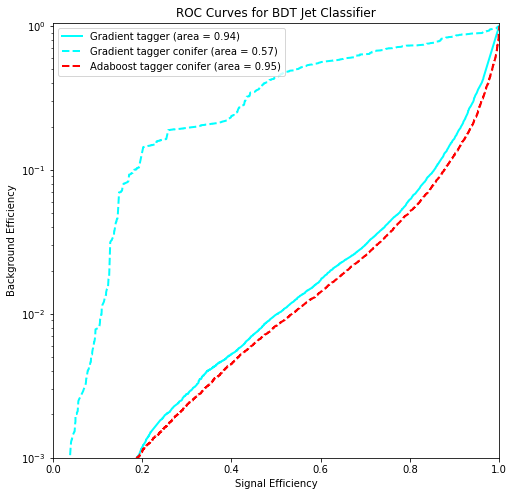

In [56]:
# Plot all ROC curves
plt.figure(figsize=[8,8])

lw=2
classes=['Gradient']
n_classes=len(list(classes))

from itertools import cycle
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(tpr[i], fpr[i], color=color, lw=lw,
             label= list(classes)[i] + ' tagger (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    plt.plot(tpr_conif[i], fpr_conif[i], '--', color=color, lw=lw,
             label= list(classes)[i] + ' tagger conifer (area = {1:0.2f})'
             ''.format(i, roc_auc_conif[i]))    
    plt.plot(tpr_ada[i], fpr_ada[i], '--', color='red', lw=lw,
             label= 'Adaboost tagger conifer (area = {1:0.2f})'
             ''.format(i, roc_auc_ada[i]))  

plt.semilogy()
plt.xlim([0.0, 1.0])
plt.ylim([10e-4, 1.05])
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Efficiency')
plt.title('ROC Curves for BDT Jet Classifier')
plt.legend(loc="upper left")
plt.show()